In [19]:
pip install umap-learn umap torch torchinfo csaps tslearn scikit-fda

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.8/88.8 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 4.8 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [28]:
pip uninstall umap -y

Found existing installation: umap 0.1.1
Uninstalling umap-0.1.1:
  Successfully uninstalled umap-0.1.1
Note: you may need to restart the kernel to use updated packages.


In [5]:
from pyspark.ml.torch.distributor import TorchDistributor 
from pyspark.context import SparkContext
from pyspark.sql.session import SparkSession
sc = SparkContext('local')
spark = SparkSession(sc)

In [30]:
import umap.umap_ as umap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import random
import torch.nn as nn
import torch.optim as optim
import math
import os
from torch.utils.data import TensorDataset, random_split, DataLoader
import torch.nn.functional as F
from tqdm.notebook import trange, tqdm
from torchinfo import summary
from scipy.interpolate import interp1d, BSpline, splrep
from csaps import csaps
from skfda.representation.interpolation import SplineInterpolation
from scipy.interpolate import UnivariateSpline
from tslearn.metrics import SoftDTWLossPyTorch
from torch.utils.data import DataLoader, TensorDataset
from scipy.spatial.distance import cdist
import seaborn as sns
from scipy import stats
import time as time
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score
import warnings


warnings.filterwarnings("ignore", category=FutureWarning)
os.makedirs('./trained_networks/example', exist_ok=True) 

In [11]:
df_raw_data = pd.read_csv('ECG5000/ecg.csv', header=None)
df_raw_data.head()

,0,1,2,3,4,5,6,7,8,9,...,131,132,133,134,135,136,137,138,139,140
0,-0.112522,-2.827204,-3.773897,-4.349751,-4.376041,-3.474986,-2.181408,-1.818286,-1.250522,-0.477492,...,0.792168,0.933541,0.796958,0.578621,0.257740,0.228077,0.123431,0.925286,0.193137,1.0
1,-1.100878,-3.996840,-4.285843,-4.506579,-4.022377,-3.234368,-1.566126,-0.992258,-0.754680,0.042321,...,0.538356,0.656881,0.787490,0.724046,0.555784,0.476333,0.773820,1.119621,-1.436250,1.0
2,-0.567088,-2.593450,-3.874230,-4.584095,-4.187449,-3.151462,-1.742940,-1.490659,-1.183580,-0.394229,...,0.886073,0.531452,0.311377,-0.021919,-0.713683,-0.532197,0.321097,0.904227,-0.421797,1.0
3,0.490473,-1.914407,-3.616364,-4.318823,-4.268016,-3.881110,-2.993280,-1.671131,-1.333884,-0.965629,...,0.350816,0.499111,0.600345,0.842069,0.952074,0.990133,1.086798,1.403011,-0.383564,1.0
4,0.800232,-0.874252,-2.384761,-3.973292,-4.338224,-3.802422,-2.534510,-1.783423,-1.594450,-0.753199,...,1.148884,0.958434,1.059025,1.371682,1.277392,0.960304,0.971020,1.614392,1.421456,1.0


In [36]:
ecgs = df_raw_data.iloc[:, :-1].values
print(ecgs)

[[-0.11252183 -2.8272038  -3.7738969  ...  0.12343082  0.92528624
   0.19313742]
 [-1.1008778  -3.9968398  -4.2858426  ...  0.77381971  1.1196209
  -1.4362499 ]
 [-0.56708802 -2.5934502  -3.8742297  ...  0.32109663  0.90422673
  -0.42179659]
 ...
 [-1.1229693  -2.2529248  -2.8676281  ... -2.874136   -2.0083694
  -1.8083338 ]
 [-0.54770461 -1.8895451  -2.8397786  ...  1.261335    1.1504486
   0.80493225]
 [-1.3517791  -2.2090058  -2.5202247  ... -2.2600228  -1.577823
  -0.68453092]]


In [38]:
from sklearn.preprocessing import StandardScaler
scaled_ecgs = StandardScaler().fit_transform(ecgs)

In [294]:
reducer = umap.UMAP()
embedding = reducer.fit_transform(scaled_ecgs)
embedding.shape

(4998, 2)

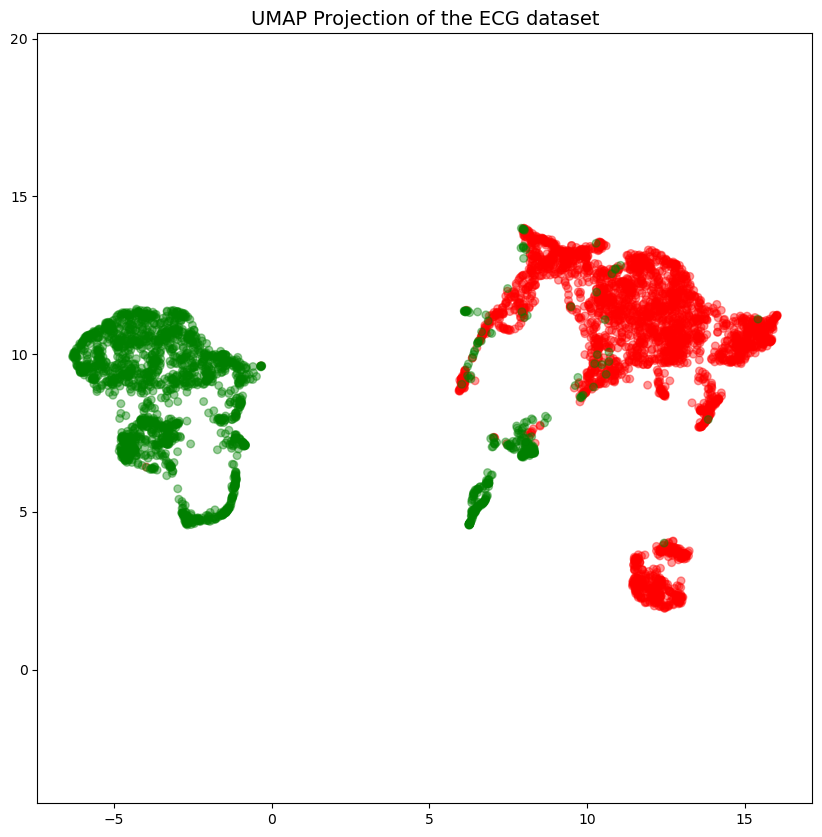

In [346]:
cmap = {0: 'g', 1: 'r'}
fig_umap = plt.figure(figsize=(10, 10))
plt.scatter(
    embedding[:, 0],
    embedding[:, 1],
    c=[cmap[x] for x in df_raw_data.iloc[:, -1].astype(int)],
    alpha=0.4,
    s=30)

plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP Projection of the ECG dataset', fontsize=14);

fig_umap.savefig('latence_umap.png', dpi=300, bbox_inches='tight')

In [41]:
from sklearn.metrics import pairwise_distances
from sklearn.manifold import trustworthiness

In [42]:
# Calculate trustworthiness
trust = trustworthiness(ecgs, embedding)
print(f"Trustworthiness: {trust}")

# Calculate pairwise distances
original_distances = pairwise_distances(ecgs)
reduced_distances = pairwise_distances(embedding)

# Calculate correlation between distances
correlation = np.corrcoef(original_distances.flatten(), reduced_distances.flatten())[0, 1]
print(f"Distance Correlation: {correlation}")

Trustworthiness: 0.9554378865774766
Distance Correlation: 0.7566222160574765


In [12]:
random_SEED = 42
np.random.seed(random_SEED)

df_raw_data = pd.read_csv('ECG5000/ecg.csv', header=None)
df_raw_data.columns = [f't{i+1}' for i in range(df_raw_data.shape[1] - 1)] + ['label'] # 4998x140 (+1 column for labels); 1: normal, 0: anomalous; 2079 normal
torch_data_normal = torch.tensor(df_raw_data[df_raw_data['label'] == True].values[:,:-1], dtype=torch.float32)
print(torch_data_normal[0, 0])
print(torch_data_normal[0, 0])
torch_data_anomalous = torch.tensor(df_raw_data[df_raw_data['label'] == False].values[:,:-1], dtype=torch.float32)
hold_out_idx = torch.tensor(random.sample(range(torch_data_normal.shape[0]), 500))
all_indices = torch.arange(torch_data_normal.shape[0])
remaining_indices = all_indices[~torch.isin(all_indices, hold_out_idx)]
hold_out_normal = torch_data_normal[hold_out_idx,:]
torch_data_normal = torch_data_normal[remaining_indices,:]
input_dim = torch_data_normal.shape[1]
print(f'input dimension is {input_dim}')
#encoding_dim = 10

tensor(-0.1125)
input dimension is 140


In [217]:
random_SEED = 42
np.random.seed(random_SEED)

df_raw_data = pd.read_csv('ECG5000/ecg.csv', header=None)
df_raw_data.columns = [f't{i+1}' for i in range(df_raw_data.shape[1] - 1)] + ['label'] # 4998x140 (+1 column for labels); 1: normal, 0: anomalous; 2079 normal
torch_data_normal = torch.tensor(df_raw_data[df_raw_data['label'] == True].values[:,:-1], dtype=torch.float32)
torch_data_anomalous = torch.tensor(df_raw_data[df_raw_data['label'] == False].values[:,:-1], dtype=torch.float32)
hold_out_idx = torch.tensor(random.sample(range(torch_data_normal.shape[0]), 500))
all_indices = torch.arange(torch_data_normal.shape[0])
remaining_indices = all_indices[~torch.isin(all_indices, hold_out_idx)]
hold_out_normal = torch_data_normal[hold_out_idx,:]
torch_data_normal = torch_data_normal[remaining_indices,:]
input_dim = torch_data_normal.shape[1]
print(f'input dimension is {input_dim}')
encoding_dim = 10

# # Uncomment to increment the size of the training data to see if the notebook is scalable
# torch_data_normal = torch.concat((torch_data_normal,torch_data_normal,torch_data_normal,torch_data_normal,torch_data_normal,torch_data_normal,
#               torch_data_normal,torch_data_normal,torch_data_normal,torch_data_normal,torch_data_normal,
#               torch_data_normal,torch_data_normal,torch_data_normal,torch_data_normal,torch_data_normal))

print(f'Training data (normal): {torch_data_normal.shape[0]}')
print(f'Anomalous data: {torch_data_anomalous.shape[0]}')
print(f'Hold-out data (normal): {hold_out_normal.shape[0]}')
print(f'Total data: {hold_out_normal.shape[0]+torch_data_anomalous.shape[0]+torch_data_normal.shape[0]}')

train_datasets = []

num_splits = 9
split_sizes = [torch_data_normal.shape[0] // num_splits] * (num_splits - 1) + [torch_data_normal.shape[0] - (torch_data_normal.shape[0] // num_splits) * (num_splits - 1)]
train_datasets = torch.split(torch_data_normal, split_sizes)
for tt_idx, tt in enumerate(train_datasets):
    print(f"{tt.shape[0]} data in chunk number {tt_idx+1}")

input dimension is 140
Training data (normal): 2419
Anomalous data: 2079
Hold-out data (normal): 500
Total data: 4998
268 data in chunk number 1
268 data in chunk number 2
268 data in chunk number 3
268 data in chunk number 4
268 data in chunk number 5
268 data in chunk number 6
268 data in chunk number 7
268 data in chunk number 8
275 data in chunk number 9


In [218]:
class TimeSeriesAutoencoder(nn.Module):
    def __init__(self, input_dim, encoding_dim):
        super(TimeSeriesAutoencoder, self).__init__()
        self.encode = nn.Sequential(
            nn.Linear(input_dim, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, encoding_dim),
        )
        
        self.decode = nn.Sequential(
            nn.Linear(encoding_dim, 16),
            nn.ReLU(),
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Linear(32, input_dim)
        )

    def forward(self, x):
        encoded = self.encode(x)
        decoded = self.decode(encoded)
        return decoded
    

models = []
for i in range(num_splits):
    models.append(TimeSeriesAutoencoder(input_dim=input_dim, encoding_dim=encoding_dim))

In [219]:
def train_data_loader(split_index, datasets, batch_size):
    """This function creates the dataloader for each node.

    Parameters
    ----------
    split_index : (int)
        The number of the assigned node (0,1,...)
    datasets : (list)
        A list of datasets
    batch_size : (int)
        Size of the minibatch

    Returns
    -------
    A dataloader for the dataset at index split_index
    """

    train_dataset_split_index = TensorDataset(datasets[split_index])
    train_dataloader_split_index = DataLoader(train_dataset_split_index, batch_size=batch_size, shuffle=True)
    
    return(train_dataloader_split_index)

def training(models, train_datasets, criterion, num_epochs, batch_size, learning_rate, print_epoch):
    """This function creates the dataloader for each node.

    Parameters
    ----------
    models : [models]
        A list of models to be trained
    train_datasets : (list)
        A list of datasets to be used for training
    criterion : (function)
        Loss function
    num_epochs : (int)
        Number of epochs to be run
    batch_size : (int)
        Size of the minibatch
    learning_rate : (float)
        The learning rate for the optimizer
    print_epoch : (int)
        Determines if we print a loss and how often, set to 0 to omit print
    Returns
    -------
    A dataloader for the dataset at index split_index
    """

    
    local_rank = int(os.environ["LOCAL_RANK"])
    
    model = models[local_rank]
    
    dataloader = train_data_loader(local_rank, train_datasets, batch_size)
    
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    for epoch in range(1,num_epochs+1):
        total_loss = 0
        for batch in dataloader:
            inputs = batch[0]
            outputs = model(inputs)
            loss = criterion(outputs, inputs)  
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        if print_epoch != 0:
            if epoch % print_epoch == 0:
                print(f"Model {local_rank} Epoch [{epoch}/{num_epochs}], Loss: {total_loss/len(dataloader):.6f}")
    
    torch.save(model.state_dict(), "./trained_networks/example/ensemble_" + str(local_rank) + ".pth")

    # # Attempted this, but it doesn't update the list accordingly
    # models[local_rank] = model
    return 

In [220]:
criterion = nn.MSELoss()

num_epochs = 100
batch_size = 32
learning_rate = 0.01

print_epoch = 0

start_time = time.time()

# run takes arguments: (<function to be run>, <arguments to be passed to function>)
TorchDistributor(num_processes=num_splits, local_mode=True, use_gpu=False).run(training, # function to run
                models, train_datasets, criterion, num_epochs, batch_size, learning_rate, print_epoch) # arguments to pass to function

print('It took ' , time.time()-start_time ,'s')

Started local training with 9 processes
INFO:TorchDistributor:Started local training with 9 processes
Finished local training with 9 processes
INFO:TorchDistributor:Finished local training with 9 processes


*****************************************
Setting OMP_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed.
*****************************************
It took  7.986127614974976 s


In [221]:
# Done at post-training, inference/evaluation
# Loads the trained models from the folder trained_networks/example
models = []
for i in range(num_splits):
    models.append(TimeSeriesAutoencoder(input_dim=input_dim, encoding_dim=encoding_dim))
    models[i].load_state_dict(torch.load("./trained_networks/example/ensemble_" + str(i) + ".pth", weights_only=True))
    models[i].eval()

In [126]:
from sklearn.preprocessing import MinMaxScaler

In [279]:
# new_patients = torch.concat((hold_out_normal, torch_data_anomalous[torch.tensor(random.sample(range(torch_data_anomalous.shape[0]), 500)),:]))
# true_labels = torch.concat((torch.ones(500), torch.zeros(500))).numpy()
# mse_loss = nn.MSELoss()

# reconstructed_new_patients_all = []
# result_all = [] 
# with torch.no_grad():
#     for i in range(num_splits):
#         i_model = models[i]
#         i_model.eval()  
#         reconstructed_new_patients_i = i_model(new_patients)
#         reconstructed_new_patients_all.append(reconstructed_new_patients_i)
#         new_patients_loss_i = []
#         normal_loss_i = []
#         for j in range(train_datasets[i].shape[0]):
#             normal_loss_i.append(mse_loss(i_model(train_datasets[i][j,:]), train_datasets[i][j,:]).numpy())
#         for j in range(new_patients.shape[0]):
#             new_patients_loss_i.append(mse_loss(reconstructed_new_patients_i[j,:], new_patients[j,:]).numpy())
#         normal_ecdf_i = stats.ecdf(normal_loss_i)
#         result_i = normal_ecdf_i.cdf.evaluate(new_patients_loss_i)
#         result_all.append(result_i)

In [228]:
new_patients = torch.concat((hold_out_normal, torch_data_anomalous[torch.tensor(random.sample(range(torch_data_anomalous.shape[0]), 500)),:]))
true_labels = torch.concat((torch.ones(500), torch.zeros(500))).numpy()
mse_loss = nn.MSELoss()

reconstructed_new_patients_all = []
result_all = []
pred_all = []
normal_loss_all = []
new_patients_loss_all = []
new_patients_ecdf_all = []

with torch.no_grad():
    for i in range(num_splits):
        i_model = models[i]
        i_model.eval()  
        reconstructed_new_patients_i = i_model(new_patients)
        reconstructed_new_patients_all.append(reconstructed_new_patients_i)
        new_patients_loss_i = []
        normal_loss_i = []
        for j in range(train_datasets[i].shape[0]):
            normal_loss_i.append(mse_loss(i_model(train_datasets[i][j,:]), train_datasets[i][j,:]).numpy())
        for j in range(new_patients.shape[0]):
            new_patients_loss_i.append(mse_loss(reconstructed_new_patients_i[j,:], new_patients[j,:]).numpy())
        
        normal_loss_all.append(normal_loss_i)
        new_patients_loss_all.append(new_patients_loss_i)
        # print(f'new_patients_loss_i: {new_patients_loss_i}')
        
        normal_loss_i_avg = np.mean(normal_loss_i)
        print(f'normal_loss_i_avg: {normal_loss_i_avg}')
        new_patient_i_ecdf = stats.ecdf(new_patients_loss_i)
        new_patients_ecdf_all.append(new_patient_i_ecdf)
        pred_i = new_patient_i_ecdf.cdf.evaluate(normal_loss_i_avg)
        print(f'pred_i: {pred_i}')
        pred_all.append(pred_i) 
        
        normal_ecdf_i = stats.ecdf(normal_loss_i)
        result_i = normal_ecdf_i.cdf.evaluate(new_patients_loss_i)
        result_all.append(result_i)

normal_loss_i_avg: 0.02849792316555977
pred_i: 0.314
normal_loss_i_avg: 0.026394473388791084
pred_i: 0.3
normal_loss_i_avg: 0.029118085280060768
pred_i: 0.275
normal_loss_i_avg: 0.029260952025651932
pred_i: 0.269
normal_loss_i_avg: 0.03381003066897392
pred_i: 0.296
normal_loss_i_avg: 0.027559617534279823
pred_i: 0.285
normal_loss_i_avg: 0.0263831689953804
pred_i: 0.253
normal_loss_i_avg: 0.02888687141239643
pred_i: 0.277
normal_loss_i_avg: 0.025782166048884392
pred_i: 0.279


In [54]:
print(result_i.shape)

(1000,)


In [235]:
new_patients_loss_all = np.array(new_patients_loss_all)

In [236]:
new_patients_loss_all.shape

(9, 1000)

In [187]:
# np.array(new_patients_loss_all)

array([[0.02488047, 0.02509749, 0.02090959, ..., 0.6580118 , 0.6129803 ,
        0.38760376],
       [0.02451707, 0.00979106, 0.01203628, ..., 0.582804  , 0.65445393,
        0.41163334],
       [0.02024186, 0.00909028, 0.01242488, ..., 0.786837  , 0.44087204,
        0.3052147 ],
       ...,
       [0.01333643, 0.00849168, 0.02166531, ..., 0.688858  , 0.60599893,
        0.44514593],
       [0.03776009, 0.01503901, 0.0198295 , ..., 0.7706098 , 0.6031939 ,
        0.39311436],
       [0.01702226, 0.00709452, 0.02121961, ..., 0.6140584 , 0.6845936 ,
        0.4445723 ]], dtype=float32)

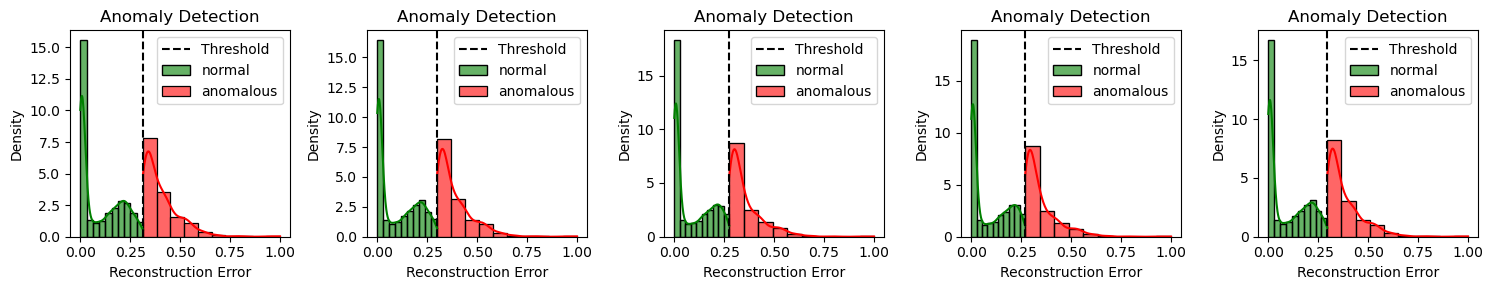

In [246]:
fig_q = plt.figure(figsize=(15, 3))  # Adjust figure size for side-by-side plots
new_patient_mse_all_np = np.array(new_patient_loss_all)
new_patient_mse_all_np = (new_patient_mse_all_np - np.min(new_patient_mse_all_np)) / (np.max(new_patient_mse_all_np) - np.min(new_patient_mse_all_np))
# scaler = MinMaxScaler()
# new_patient_mse_all_np_reshaped = new_patient_mse_all_np.reshape(-1, 1)
# new_patient_mse_all_np_scaled = scaler.fit_transform(new_patient_mse_all_np_reshaped)
# new_patient_mse_all_np = new_patient_mse_all_np_scaled.flatten()

for i in range(5):
    plt.subplot(1, 5, i + 1)  # Create 5 side-by-side subplots
    # data_i = new_patient_mse_all_np
    # Extract the ECDF data for the current model
    threshold = pred_all[i]
    normal_mse = new_patient_mse_all_np[new_patient_mse_all_np <= threshold]
    anomalous_mse = new_patient_mse_all_np[new_patient_mse_all_np > threshold]
    
    # Plot the histogram for data below the threshold
    sns.histplot(normal_mse, bins=10, kde=True, color='green', alpha=0.6, stat='density', common_norm=True, label='normal')
    
    # Plot the histogram for data above the threshold
    sns.histplot(anomalous_mse, bins=10, kde=True, color='red', alpha=0.6, stat='density', common_norm=True, label='anomalous')
    
    # Add a vertical line for the threshold
    plt.axvline(threshold, color='black', linestyle='--', label='Threshold')

    # sns.histplot(data_i, bins=20, kde=True, color='green', alpha=0.6, stat='density', label='Count')

    
    # Add labels and title
    plt.xlabel('Reconstruction Error')
    plt.ylabel('Density')
    plt.title('Anomaly Detection')
    plt.legend()

plt.tight_layout()
# Save the figure
fig_q.savefig('hist-threshold.png', dpi=300, bbox_inches='tight')
plt.show()

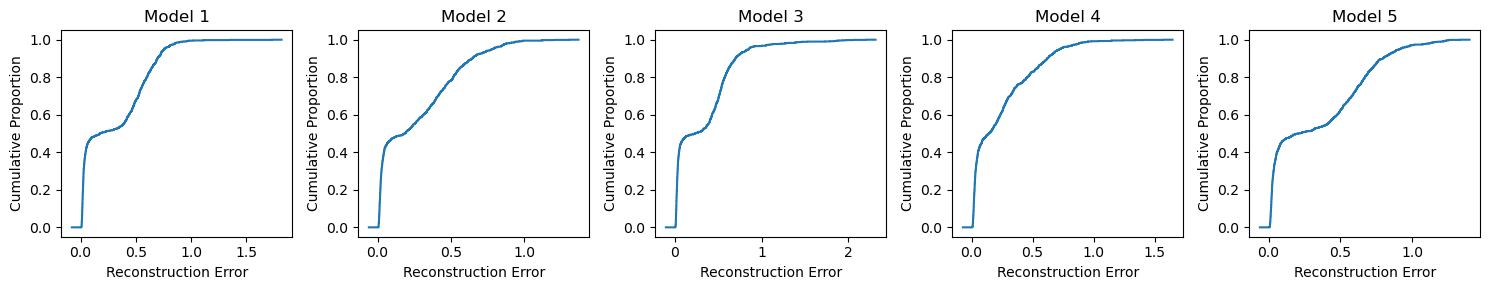

In [230]:
fig_c = plt.figure(figsize=(15, 3))  # Adjust figure size for side-by-side plots

for i in range(5):
    ax = plt.subplot(1, 5, i + 1)  # Create 5 side-by-side subplots

    # Extract the ECDF data for the current model
    ecdf_i = new_patients_ecdf_all[i]
    threshold_i = pred_all[i]
    ecdf_values = ecdf_i.cdf.evaluate(threshold_i)
    ecdf_i.cdf.plot(ax)

    plt.title(f"Model {i + 1}")
    plt.xlabel('Reconstruction Error')
    plt.ylabel('Cumulative Proportion')

plt.tight_layout()
# Save the figure
fig_c.savefig('cdf-cumulative.png', dpi=300, bbox_inches='tight')
plt.show()

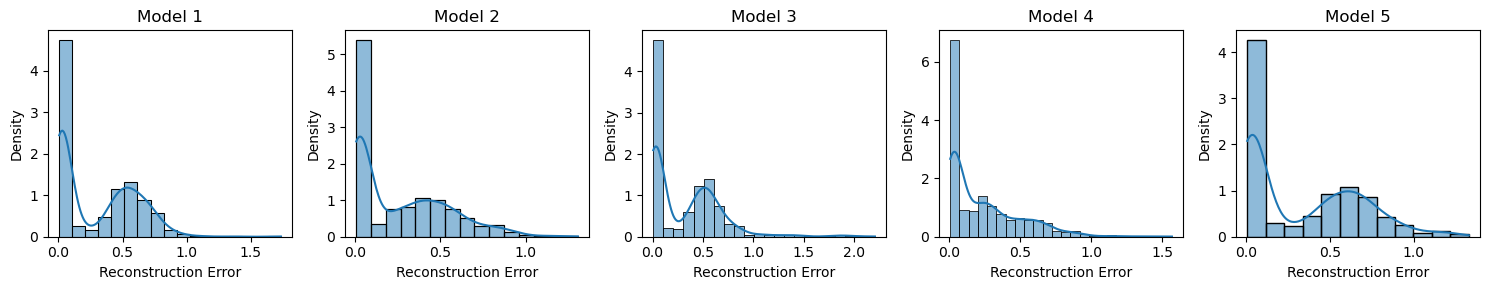

In [284]:
fig_e = plt.figure(figsize=(15, 3))  # Adjust figure size for side-by-side plots

for i in range(5):
    plt.subplot(1, 5, i + 1)  # Create 5 side-by-side subplots

    # Extract the ECDF data for the current model
    # sns.ecdfplot(data=new_patients_loss_all[i])
    sns.histplot(data=new_patients_loss_all[i], stat='density', kde=True)

    plt.title(f"Model {i + 1}")
    plt.xlabel('Reconstruction Error')
    plt.ylabel('Density')

plt.tight_layout()
# Save the figure
fig_e.savefig('hist-kde-v2.png', dpi=300, bbox_inches='tight')
plt.show()

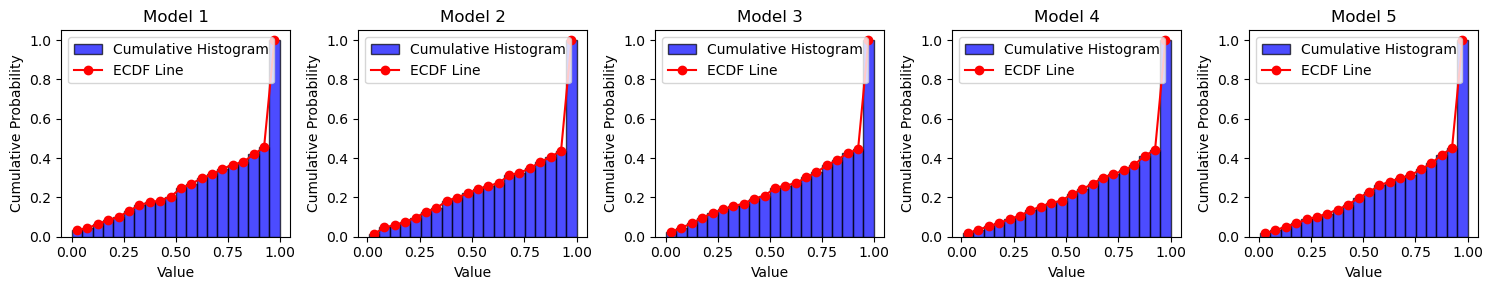

In [281]:
fig = plt.figure(figsize=(15, 3))  # Adjust figure size for side-by-side plots

for i in range(5):
    plt.subplot(1, 5, i + 1)  # Create 5 side-by-side subplots

    # Extract the ECDF data for the current model
    ecdf_values = result_all[i]

    # Plot cumulative histogram
    counts, bins, _ = plt.hist(
        ecdf_values,
        bins=20,  # Adjust number of bins as needed
        cumulative=True,
        color='blue',
        alpha=0.7,
        edgecolor='black',
        density=True,  # Normalize for ECDF-like visualization
        label="Cumulative Histogram"
    )

    # Calculate the midpoints of bins for the cumulative line
    bin_centers = (bins[:-1] + bins[1:]) / 2

    # Plot the cumulative ECDF line
    plt.plot(
        bin_centers,
        counts,
        marker='o',
        color='red',
        label="ECDF Line"
    )

    plt.title(f"Model {i + 1}")
    plt.xlabel('Value')
    plt.ylabel('Cumulative Probability')
    plt.legend()

plt.tight_layout()
# Save the figure
fig.savefig('ecdf-cumulative-histogam-2.png', dpi=300, bbox_inches='tight')
plt.show()

In [89]:
result_mse_all_np = np.array(result_all)
threshold = 0.05
normal_mse = result_mse_all_np[result_mse_all_np <= threshold]
anomalous_mse = result_mse_all_np[result_mse_all_np > threshold]

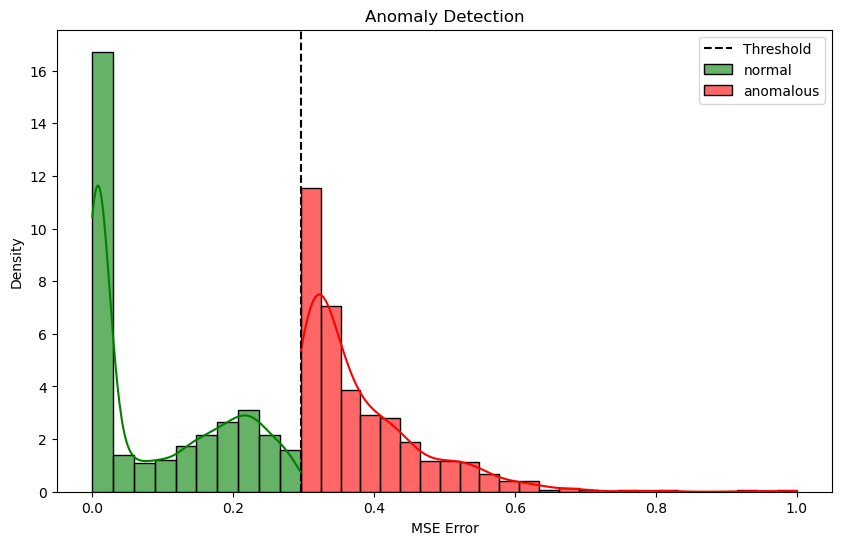

In [263]:
fig_mse = plt.figure(figsize=(10, 6))

# Plot the histogram for data below the threshold
sns.histplot(normal_mse, bins=10, kde=True, color='green', alpha=0.6, common_bins=False, common_norm=False, stat='density', label='normal')

# Plot the histogram for data above the threshold
sns.histplot(anomalous_mse, bins=25, kde=True, color='red', alpha=0.6, common_bins=False, common_norm=False, stat='density', label='anomalous')

# Add a vertical line for the threshold
plt.axvline(threshold, color='black', linestyle='--', label='Threshold')

# Add labels and title
plt.xlabel('MSE Error')
plt.ylabel('Density')
plt.title('Anomaly Detection')
plt.legend()

# Show the plot
fig_mse.savefig('mse-histogam-density.png', dpi=300, bbox_inches='tight')
plt.show()

In [91]:
result_all_np = np.array(result_all)
threshold = 0.05
normal = result_all_np[result_all_np <= threshold]
anomalous = result_all_np[result_all_np > threshold]

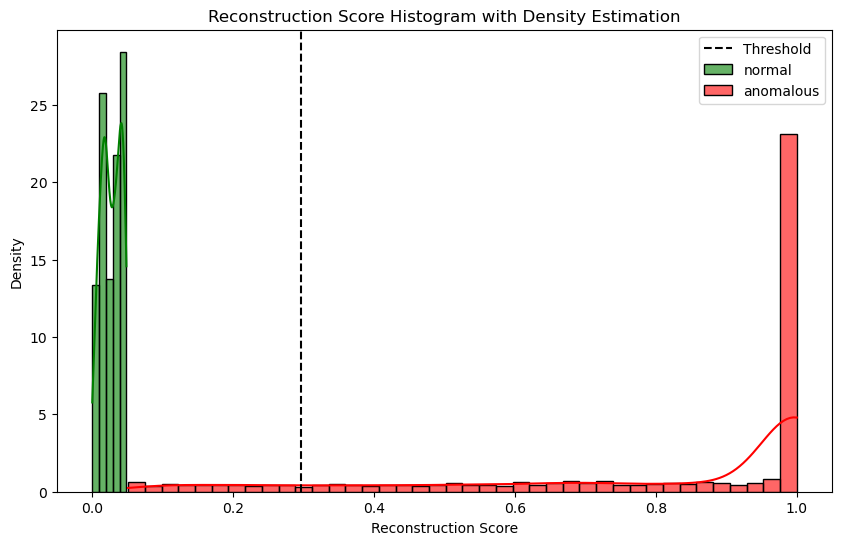

In [268]:
fig1 = plt.figure(figsize=(10, 6))

# Plot the histogram for data below the threshold
sns.histplot(normal, bins=5, kde=True, color='green', alpha=0.6, stat='density', label='normal')

# Plot the histogram for data above the threshold
sns.histplot(anomalous, bins=40, kde=True, color='red', alpha=0.6, stat='density', label='anomalous')

# Add a vertical line for the threshold
plt.axvline(threshold, color='black', linestyle='--', label='Threshold')

# Add labels and title
plt.xlabel('Reconstruction Score')
plt.ylabel('Density')
plt.title('Reconstruction Score Histogram with Density Estimation')
plt.legend()

# Show the plot
fig1.savefig('recon-histogam-density.png', dpi=300, bbox_inches='tight')
plt.show()

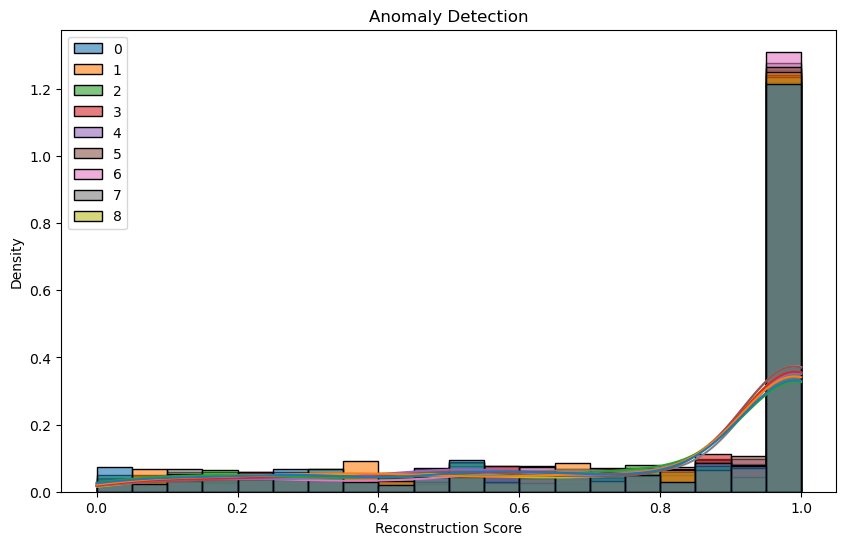

In [274]:
fig_k = plt.figure(figsize=(10, 6))

# Plot the histogram
sns.histplot(result_all, bins=20, kde=True, color='blue', alpha=0.6, stat='density')

# Add labels and title
plt.xlabel('Reconstruction Score')
plt.ylabel('Density')
plt.title('Anomaly Detection')

# Show the plot
fig_k.savefig('recon-histogam-density-kde.png', dpi=300, bbox_inches='tight')
plt.show()

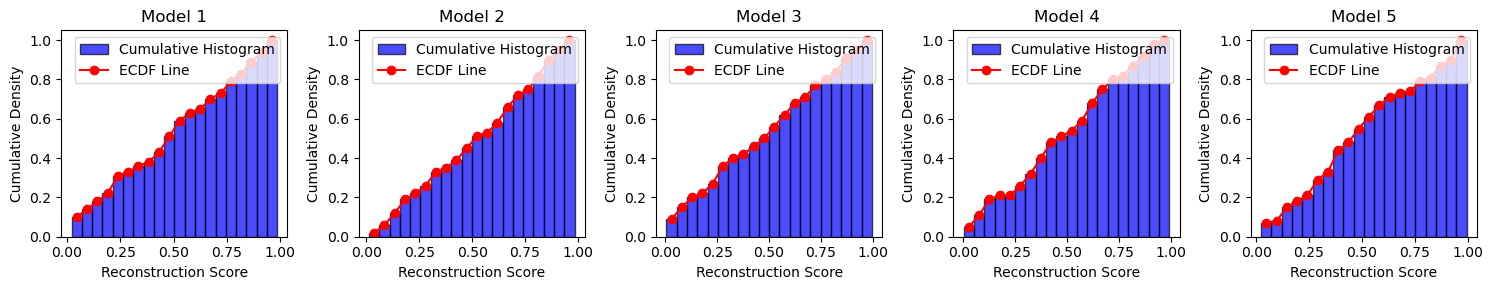

In [287]:
import numpy as np
import matplotlib.pyplot as plt

# Example: Assuming `result_all` is a list of arrays with ECDF results for each model
result_all_fk = [np.random.rand(100) for _ in range(5)]  # Replace with actual ECDF results

fig_f = plt.figure(figsize=(15, 3))  # Adjust figure size for side-by-side plots

for i in range(5):
    plt.subplot(1, 5, i + 1)  # Create 5 side-by-side subplots

    # Plot histogram
    counts, bins, _ = plt.hist(
        result_all_fk[i],
        bins=20,  # Number of bins
        cumulative=True,
        color='blue',
        alpha=0.7,
        edgecolor='black',
        density=True,  # Normalize to plot ECDF
        label="Cumulative Histogram"
    )

    # Compute midpoints of bins for the ECDF line
    bin_centers = (bins[:-1] + bins[1:]) / 2

    # Plot the ECDF line
    plt.plot(
        bin_centers,
        counts,
        marker='o',
        color='red',
        label="ECDF Line"
    )

    plt.title(f"Model {i+1}")
    plt.xlabel('Reconstruction Score')  # Adjust axis labels if needed
    plt.ylabel('Cumulative Density')
    plt.legend()

plt.tight_layout()
fig_f.savefig('ecdf-cumulative-histogam-fake.png', dpi=300, bbox_inches='tight')
plt.show()

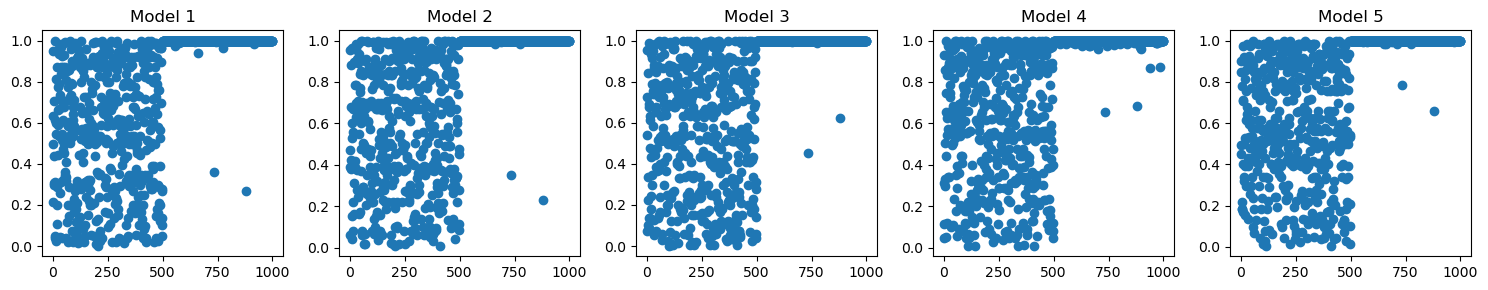

In [280]:
plt.figure(figsize=(15, 3))  # Adjust figure size for side-by-side plots
for i in range(5):
    plt.subplot(1, 5, i + 1)  # Create 5 side-by-side subplots
    plt.scatter(range(len(result_all[i])), result_all[i])
    # plt.plot(range(len(result_all[i])), result_all[i])
    plt.title(f"Model {i+1}")
plt.tight_layout()
plt.show()

In [10]:
alpha = 0.05

selected_indices_all = []
predicted_labels_all = []
cm_all = []
accuracy_all = []
precision_all = []
recall_all = []

for i in range(num_splits):
    result_i = result_all[i]
    selected_indices_i = np.where(result_i > 1-alpha)
    selected_indices_all.append(selected_indices_i)
    selected_values_i = result_i[selected_indices_i]

    predicted_labels_i = np.ones_like(true_labels)
    predicted_labels_i[selected_indices_i] = 0
    predicted_labels_all.append(predicted_labels_i)

    cm_i = confusion_matrix(true_labels, predicted_labels_i)
    cm_all.append(cm_i)

    print(f"Confusion Matrix from model {i+1}:")
    print(cm_i)

    accuracy_i = accuracy_score(true_labels, predicted_labels_i)
    accuracy_all.append(accuracy_i)
    precision_i = precision_score(true_labels, predicted_labels_i)
    precision_all.append(precision_i)
    recall_i = recall_score(true_labels, predicted_labels_i)
    recall_all.append(recall_i)

    print(f"Accuracy from model {i+1}: {accuracy_i}")
    print(f"Precision from model {i+1}: {precision_i}")
    print(f"Recall from model {i+1}: {recall_i}")

Confusion Matrix from model 1:
[[500   0]
 [ 74 426]]
Accuracy from model 1: 0.926
Precision from model 1: 1.0
Recall from model 1: 0.852
Confusion Matrix from model 2:
[[500   0]
 [ 64 436]]
Accuracy from model 2: 0.936
Precision from model 2: 1.0
Recall from model 2: 0.872
Confusion Matrix from model 3:
[[500   0]
 [ 84 416]]
Accuracy from model 3: 0.916
Precision from model 3: 1.0
Recall from model 3: 0.832
Confusion Matrix from model 4:
[[500   0]
 [ 50 450]]
Accuracy from model 4: 0.95
Precision from model 4: 1.0
Recall from model 4: 0.9
Confusion Matrix from model 5:
[[500   0]
 [ 52 448]]
Accuracy from model 5: 0.948
Precision from model 5: 1.0
Recall from model 5: 0.896
Confusion Matrix from model 6:
[[500   0]
 [ 79 421]]
Accuracy from model 6: 0.921
Precision from model 6: 1.0
Recall from model 6: 0.842
Confusion Matrix from model 7:
[[500   0]
 [ 83 417]]
Accuracy from model 7: 0.917
Precision from model 7: 1.0
Recall from model 7: 0.834
Confusion Matrix from model 8:
[[500 